**Imports + helpers**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_blobs
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

**Générer & visualiser données (1D/2D/3D/4D + 2 distributions)**

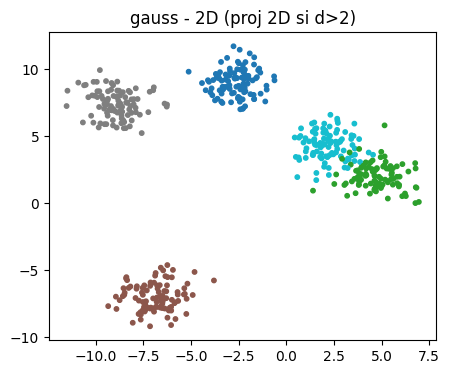

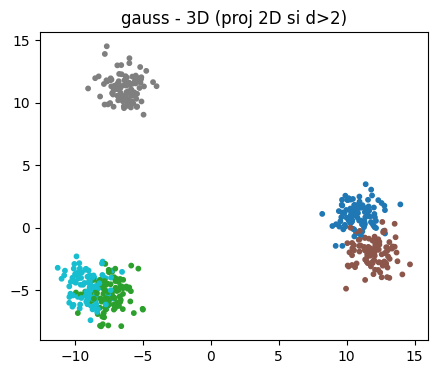

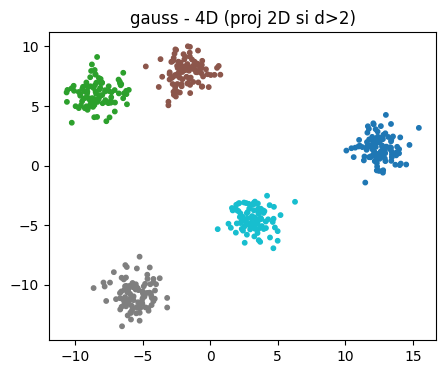

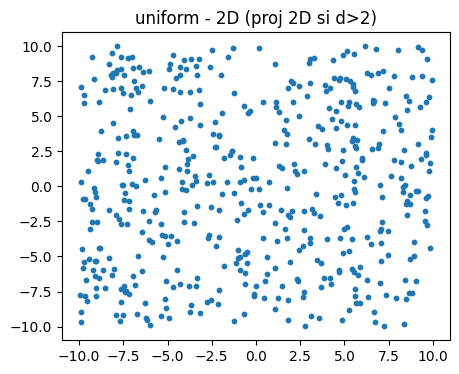

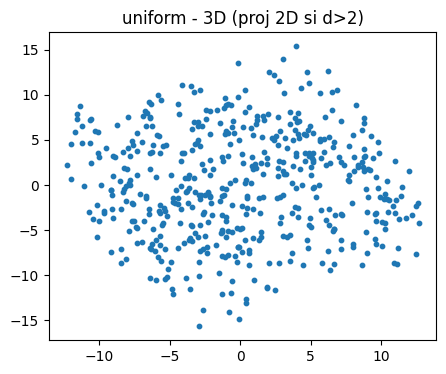

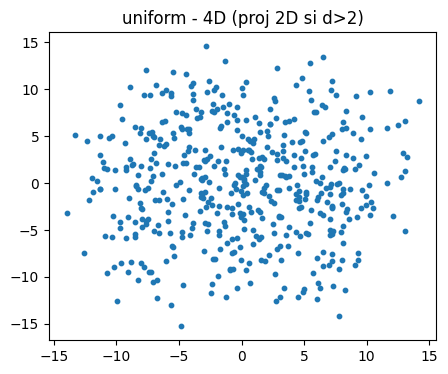

In [2]:
def make_gaussian_data(n=500, d=2, k=5, cluster_std=1.0, seed=42):
    X, y = make_blobs(n_samples=n, centers=k, n_features=d,
                      cluster_std=cluster_std, random_state=seed)
    return X, y

def make_uniform_data(n=500, d=2, low=-10, high=10, seed=42):
    rng = np.random.default_rng(seed)
    X = rng.uniform(low, high, size=(n, d))
    y = None
    return X, y

def visualize_data_2d(X, y=None, title=""):
    d = X.shape[1]
    X2 = X if d == 2 else PCA(n_components=2).fit_transform(X)
    plt.figure(figsize=(5,4))
    if y is None:
        plt.scatter(X2[:,0], X2[:,1], s=10)
    else:
        plt.scatter(X2[:,0], X2[:,1], c=y, s=10, cmap="tab10")
    plt.title(title)
    plt.show()

# Construire la liste des datasets à tester (gauss + uniforme, 1D..4D)
datasets = {}
for dist in ["gauss", "uniform"]:
    for d in [1,2,3,4]:
        if dist == "gauss":
            datasets[(dist, d)] = make_gaussian_data(n=500, d=d, k=5, seed=42)
        else:
            datasets[(dist, d)] = make_uniform_data(n=500, d=d, seed=42)

# Visualiser au moins les cas 2D (et projeter 3D/4D en 2D avec PCA)
for (dist, d), (X, y) in datasets.items():
    if d >= 2:
        visualize_data_2d(X, y, title=f"{dist} - {d}D (proj 2D si d>2)")
